# **Importando Bibliotecas**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from datetime import timedelta
from IPython.display import display
from scipy import special
from random import sample
from sklearn.metrics import confusion_matrix
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

# **Importando Dados**

In [0]:
fraude_df = pd.read_csv('dados_de_fraude.csv', header=0)
ISP_df = pd.read_csv('endereco_ip_por_pais.csv', header=0)

In [92]:
fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [93]:
ISP_df.head()

,limite_inferior_ip,limite_superior_ip,pais
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [94]:
print('Fraude - DF: Linhas {} e Colunas {}'.format(fraude_df.shape[0], fraude_df.shape[1]))
print('ISP - DF: Linhas {} e Colunas {}'.format(ISP_df.shape[0], ISP_df.shape[1]))

Fraude - DF: Linhas 151112 e Colunas 11
ISP - DF: Linhas 138846 e Colunas 3


# **Tratamento dos Dados**

In [95]:
fraude_df.dtypes

id                  int64
cadastro           object
compra             object
valor               int64
id_dispositivo     object
fonte              object
browser            object
genero             object
idade               int64
ip                float64
fraude              int64
dtype: object

In [96]:
print('Verificando Valores Nulos - Fraude DF')
fraude_df.isnull().sum()

Verificando Valores Nulos - Fraude DF


id                0
cadastro          0
compra            0
valor             0
id_dispositivo    0
fonte             0
browser           0
genero            0
idade             0
ip                0
fraude            0
dtype: int64

In [97]:
print('Verificando Valores Nulos - ISP DF')
ISP_df.isnull().sum()

Verificando Valores Nulos - ISP DF


limite_inferior_ip    0
limite_superior_ip    0
pais                  0
dtype: int64

In [0]:
def isp_counts(isp):
    pais = ISP_df[(ISP_df.limite_inferior_ip <= isp) & (ISP_df.limite_superior_ip >= isp)].pais
    if pais.shape[0] == 1:
        return 'Único'
    elif pais.shape[0] > 1:
        return 'Vários países'
    elif pais.shape[0] == 0:
        if isp > ISP_df.limite_superior_ip.max():
            return 'Muito grande'
        elif isp < ISP_df.limite_inferior_ip.min():
            return 'Muito pequeno'
        else:
            return 'Faltando'

def ip_para_pais(ip):
    tmp = ISP_df[(ISP_df.limite_inferior_ip <= ip)
                & (ISP_df.limite_superior_ip >= ip)].pais
    if tmp.shape[0] == 1:
        return tmp.iloc[0]
    elif tmp.shape[0] < 1:
        return 'Faltando'
    elif tmp.shape[0] > 1:
        return 'Erro'

In [0]:
ip_counts = fraude_df['ip'].apply(isp_counts)
fraude_df['pais'] = fraude_df['ip'].apply(ip_para_pais)
ISP_df['limite_inferior_ip'] = ISP_df['limite_inferior_ip'].astype(int)

# **Análise de Dados**

In [100]:
fraude_df.describe()

,id,valor,idade,ip,fraude
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [101]:
ISP_df.describe()

,limite_inferior_ip,limite_superior_ip
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


[Text(0, 0.5, 'Quantidade'), Text(0.5, 0, 'Gênero')]

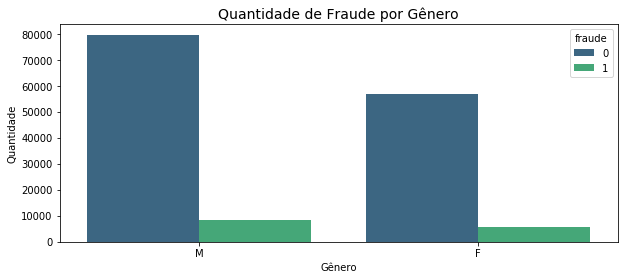

In [102]:
ax = sns.countplot(x='genero', hue='fraude', data=fraude_df, palette='viridis')
ax.figure.set_size_inches(10, 4)
ax.set_title('Quantidade de Fraude por Gênero', fontsize=14)
ax.set(xlabel='Gênero', ylabel='Quantidade')

**Podemos ver que, ambos gêneros possuem fraudes, mas podemos destacar que o gênero masculino possui mais fraudes do que o feminino.**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


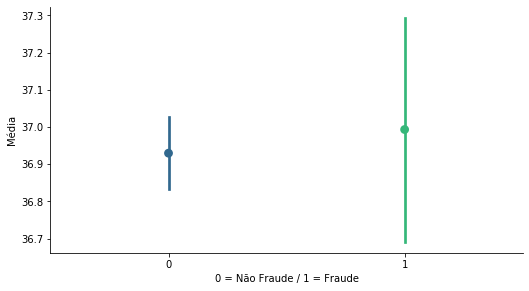

In [103]:
ax = sns.factorplot(x='fraude', y='valor', data = fraude_df, palette='viridis')
ax.fig.set_size_inches(8, 4)
ax.set(xlabel='0 = Não Fraude / 1 = Fraude', ylabel='Média')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


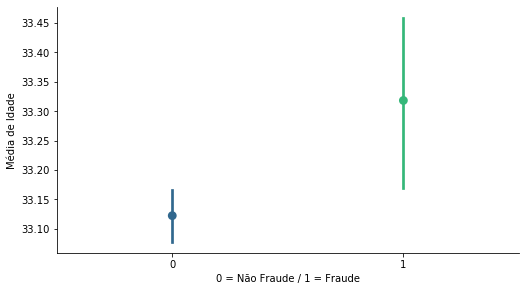

In [104]:
ax = sns.factorplot(x='fraude', y='idade', data = fraude_df, palette='viridis')
ax.fig.set_size_inches(8, 4)
ax.set(xlabel='0 = Não Fraude / 1 = Fraude', ylabel='Média de Idade')

[Text(0, 0.5, 'Quantidade'), Text(0.5, 0, 'Fonte')]

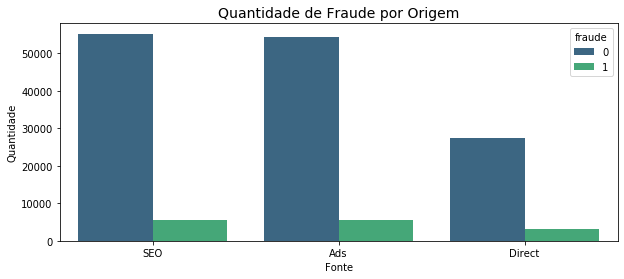

In [105]:
ax = sns.countplot(x='fonte', hue='fraude', data=fraude_df, palette='viridis')
ax.figure.set_size_inches(10, 4)
ax.set_title('Quantidade de Fraude por Origem', fontsize=14)
ax.set(xlabel='Fonte', ylabel='Quantidade')

In [0]:
tmp_df = pd.DataFrame(columns=('fraude', 'id_por_dispositivo', 'id_por_ip'))
tmp_df['fraude'] = fraude_df['fraude']

userid_count = fraude_df.groupby('id_dispositivo').id.count()
tmp_df['id_por_dispositivo'] = fraude_df.id_dispositivo.apply(lambda x: userid_count[x])
fraude_df['id_por_dispositivo'] = fraude_df.id_dispositivo.apply(lambda x: userid_count[x])

userid_count2 = fraude_df.groupby('ip').id.count()
tmp_df['id_por_ip'] = fraude_df.ip.apply(lambda x: userid_count2[x])
fraude_df['id_por_ip'] = fraude_df.ip.apply(lambda x: userid_count2[x])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


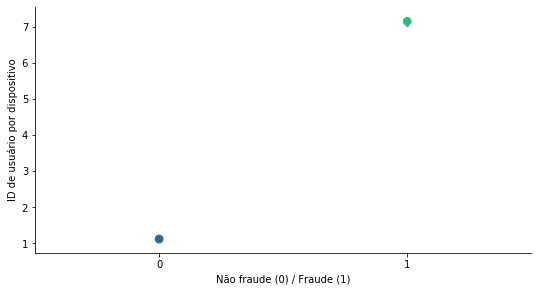

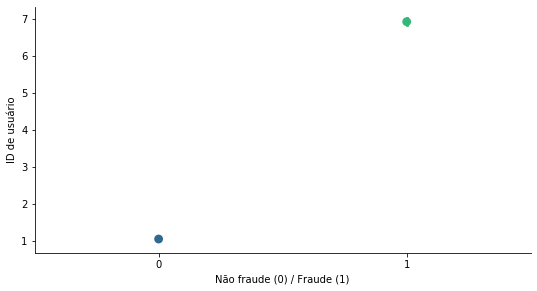

In [107]:
ax = sns.factorplot(x='fraude', y='id_por_dispositivo', data=tmp_df, palette='viridis')
ax.fig.set_size_inches(8, 4)
ax.set(xlabel='Não fraude (0) / Fraude (1)', ylabel='ID de usuário por dispositivo')

ax = sns.factorplot(x='fraude', y='id_por_ip', data=tmp_df, palette='viridis')
ax.fig.set_size_inches(8, 4)
ax.set(xlabel='Não fraude (0) / Fraude (1)', ylabel='ID de usuário')

In [0]:
tmp_df['cadastro'] = fraude_df.cadastro.apply(pd.to_datetime)
tmp_df['compra'] = fraude_df.compra.apply(pd.to_datetime)
tmp_df['tempo'] = (tmp_df.compra - tmp_df.cadastro).apply(lambda x: x.seconds)

fraude_df['cadastro'] = fraude_df.cadastro.apply(pd.to_datetime)
fraude_df['compra'] = fraude_df.compra.apply(pd.to_datetime)
fraude_df['tempo'] = (tmp_df.compra - tmp_df.cadastro).apply(lambda x: x.seconds)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


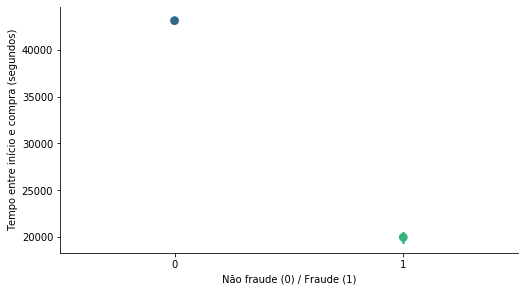

In [116]:
ax = sns.factorplot(x='fraude', y='tempo', data=tmp_df, palette='viridis')
ax.fig.set_size_inches(8, 4)
ax.set(xlabel='Não fraude (0) / Fraude (1)', ylabel='Tempo entre início e compra (segundos)')

[Text(0, 0.5, 'Contagem'), Text(0.5, 0, 'Hora do Dia')]

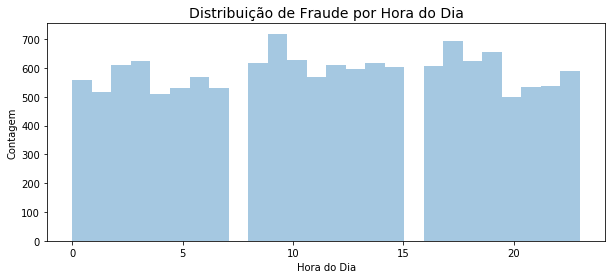

In [117]:
ax = sns.distplot(tmp_df[tmp_df['fraude'] == 1].cadastro.apply(lambda x: x.hour), kde=False)
ax.figure.set_size_inches(10, 4)
ax.set_title('Distribuição de Fraude por Hora do Dia', fontsize=14)
ax.set(xlabel='Hora do Dia', ylabel='Contagem')

[Text(0, 0.5, 'Contagem'), Text(0.5, 0, 'Dia da Semana')]

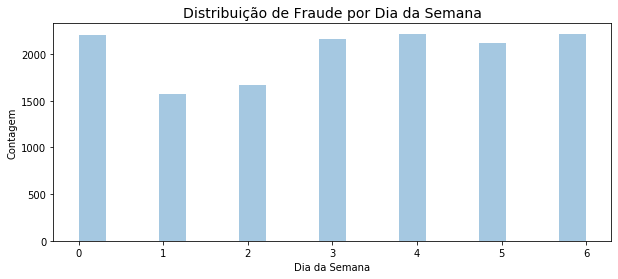

In [118]:
ax = sns.distplot(tmp_df[tmp_df['fraude'] == 1].cadastro.apply(lambda x: x.dayofweek), kde=False)
ax.figure.set_size_inches(10, 4)
ax.set_title('Distribuição de Fraude por Dia da Semana', fontsize=14)
ax.set(xlabel='Dia da Semana', ylabel='Contagem')

[Text(0, 0.5, 'Contagem'), Text(0.5, 0, 'Semana do ano')]

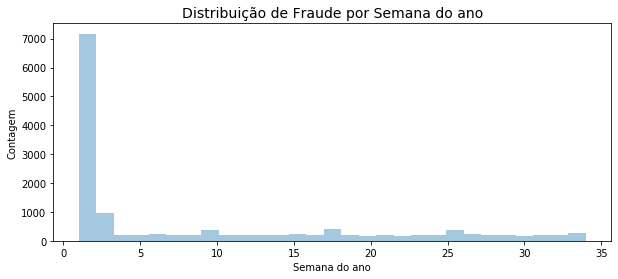

In [119]:
ax = sns.distplot(tmp_df[tmp_df['fraude'] == 1].cadastro.apply(lambda x: x.week), kde=False)
ax.figure.set_size_inches(10, 4)
ax.set_title('Distribuição de Fraude por Semana do ano', fontsize=14)
ax.set(xlabel='Semana do ano', ylabel='Contagem')

In [120]:
pais_dummies = pd.get_dummies(fraude_df.pais, prefix='pais')
fraude_df = pd.concat([fraude_df, pais_dummies], axis=1)
fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,pais_Australia,pais_Austria,pais_Azerbaijan,pais_Bahamas,pais_Bahrain,pais_Bangladesh,pais_Barbados,pais_Belarus,pais_Belgium,pais_Belize,pais_Benin,pais_Bermuda,pais_Bhutan,pais_Bolivia,pais_Bonaire; Sint Eustatius; Saba,pais_Bosnia and Herzegowina,pais_Botswana,pais_Brazil,pais_British Indian Ocean Territory,pais_Brunei Darussalam,pais_Bulgaria,...,pais_Saint Kitts and Nevis,pais_Saint Martin,pais_San Marino,pais_Saudi Arabia,pais_Senegal,pais_Serbia,pais_Seychelles,pais_Singapore,pais_Slovakia (SLOVAK Republic),pais_Slovenia,pais_South Africa,pais_South Sudan,pais_Spain,pais_Sri Lanka,pais_Sudan,pais_Sweden,pais_Switzerland,pais_Syrian Arab Republic,pais_Taiwan; Republic of China (ROC),pais_Tajikistan,pais_Tanzania United Republic of,pais_Thailand,pais_Trinidad and Tobago,pais_Tunisia,pais_Turkey,pais_Turkmenistan,pais_Uganda,pais_Ukraine,pais_United Arab Emirates,pais_United Kingdom,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Faltando,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


[Text(0, 0.5, 'Contagem'), Text(0.5, 0, 'Nº Médio de IDs')]

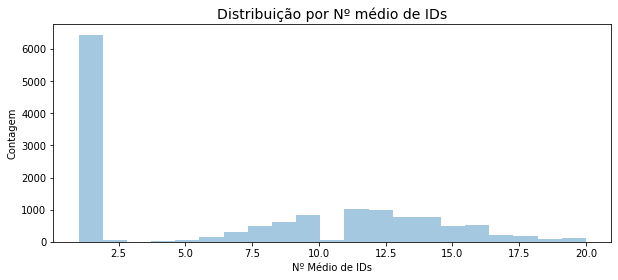

In [125]:
fraude_df['media_id'] = (fraude_df['id_por_dispositivo'] + fraude_df['id_por_ip']) * 0.5

ax = sns.distplot(fraude_df[fraude_df['fraude'] == 1]['media_id'], kde=False)
ax.figure.set_size_inches(10, 4)
ax.set_title('Distribuição por Nº médio de IDs', fontsize=14)
ax.set(xlabel='Nº Médio de IDs', ylabel='Contagem')

[Text(0, 0.5, 'Contagem'),
 Text(0.5, 0, 'Tempo de compra e inscrição (segundos)')]

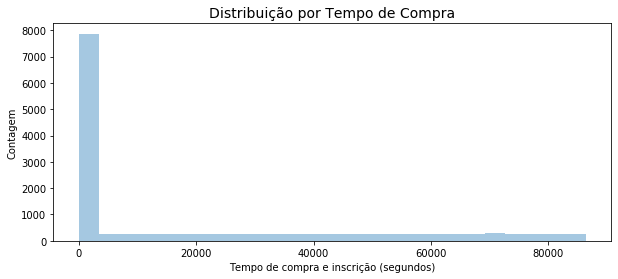

In [126]:
ax = sns.distplot(fraude_df[fraude_df['fraude'] == 1]['tempo'], kde=False, bins=25)
ax.figure.set_size_inches(10, 4)
ax.set_title('Distribuição por Tempo de Compra', fontsize=14)
ax.set(xlabel='Tempo de compra e inscrição (segundos)', ylabel='Contagem')

# **Preparação do Conjunto de Dados**

In [131]:
userid_count3 = fraude_df.groupby('id_dispositivo')['id'].count()
fraude_df['id_por_dispositivo'] = fraude_df['id_dispositivo'].apply(lambda x: userid_count3[x])

userid_count4 = fraude_df.groupby('ip')['id'].count()
fraude_df['id_por_ip'] = fraude_df['ip'].apply(lambda x: userid_count4[x])

# fraude_df['media_id'] = (fraude_df['id_por_dispositivo'] + fraude_df['id_por_ip']) * 0.5
# fraude_df['cadastro'] = fraude_df['cadastro'].apply(pd.to_datetime)
# fraude_df['compra'] = fraude_df['compra'].apply(pd.to_datetime)
# fraude_df['tempo'] = (fraude_df['compra'] - fraude_df['cadastro']).apply(lambda x: x.seconds)

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,pais_Australia,pais_Austria,pais_Azerbaijan,pais_Bahamas,pais_Bahrain,pais_Bangladesh,pais_Barbados,pais_Belarus,pais_Belgium,pais_Belize,pais_Benin,pais_Bermuda,pais_Bhutan,pais_Bolivia,pais_Bonaire; Sint Eustatius; Saba,pais_Bosnia and Herzegowina,pais_Botswana,pais_Brazil,pais_British Indian Ocean Territory,pais_Brunei Darussalam,pais_Bulgaria,...,pais_Saudi Arabia,pais_Senegal,pais_Serbia,pais_Seychelles,pais_Singapore,pais_Slovakia (SLOVAK Republic),pais_Slovenia,pais_South Africa,pais_South Sudan,pais_Spain,pais_Sri Lanka,pais_Sudan,pais_Sweden,pais_Switzerland,pais_Syrian Arab Republic,pais_Taiwan; Republic of China (ROC),pais_Tajikistan,pais_Tanzania United Republic of,pais_Thailand,pais_Trinidad and Tobago,pais_Tunisia,pais_Turkey,pais_Turkmenistan,pais_Uganda,pais_Ukraine,pais_United Arab Emirates,pais_United Kingdom,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe,id_por_dispositivo,id_por_ip,media_id
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,12,12,12.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Faltando,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1.0


In [132]:
pais_dummies = pd.get_dummies(fraude_df['pais'], prefix='pais')
fraude_df = pd.concat([fraude_df, pais_dummies], axis=1)
fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,pais_Australia,pais_Austria,pais_Azerbaijan,pais_Bahamas,pais_Bahrain,pais_Bangladesh,pais_Barbados,pais_Belarus,pais_Belgium,pais_Belize,pais_Benin,pais_Bermuda,pais_Bhutan,pais_Bolivia,pais_Bonaire; Sint Eustatius; Saba,pais_Bosnia and Herzegowina,pais_Botswana,pais_Brazil,pais_British Indian Ocean Territory,pais_Brunei Darussalam,pais_Bulgaria,...,pais_Saint Kitts and Nevis,pais_Saint Martin,pais_San Marino,pais_Saudi Arabia,pais_Senegal,pais_Serbia,pais_Seychelles,pais_Singapore,pais_Slovakia (SLOVAK Republic),pais_Slovenia,pais_South Africa,pais_South Sudan,pais_Spain,pais_Sri Lanka,pais_Sudan,pais_Sweden,pais_Switzerland,pais_Syrian Arab Republic,pais_Taiwan; Republic of China (ROC),pais_Tajikistan,pais_Tanzania United Republic of,pais_Thailand,pais_Trinidad and Tobago,pais_Tunisia,pais_Turkey,pais_Turkmenistan,pais_Uganda,pais_Ukraine,pais_United Arab Emirates,pais_United Kingdom,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Faltando,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


# **Geração do Modelo**

In [0]:
colunas_a_remover = [
  'id',
  'cadastro',
  'compra',
  'id_dispositivo',
  'ip',
  'id_por_dispositivo',
  'id_por_ip',
  'pais',
  'fonte',
  'browser',
  'genero',
  'idade',
  'valor'
]

fraude_df.drop(columns=colunas_a_remover, axis=1, inplace = True)

In [0]:
onehotencoded = [
  feature for feature in fraude_df.columns if 'pais' not in feature and feature !='fraude'
]

X = fraude_df[[col for col in fraude_df.columns if col != 'fraude']]
Y = fraude_df[['fraude']]
X.index = range(len(X))
Y.index = range(len(Y))

In [156]:
# Seleção de Features
clf = ExtraTreesClassifier()
clf.fit(X, Y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importancia'] = clf.feature_importances_
features[features.importancia > np.mean(features.importancia)].sort_values(by='importancia', ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


,feature,importancia
546,tempo,0.551003
1093,media_id,0.442051


In [0]:
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size = 0.75, random_state = 23)
Y_dev = Y_dev.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

In [159]:
IF = IsolationForest(max_samples='auto', contamination = 0.095, random_state=1)

param_grid = {
    'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500]
}

clf = GridSearchCV(IF,
                   param_grid,
                   cv=2,
                   n_jobs=3,
                   scoring='f1',
                   verbose=10)

clf.fit(X_dev, Y_dev)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: ignored

In [0]:
IF_best = clf.best_estimator_
Y_predicted = IF_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval,Y_predicted)

print(classification_report(Y_eval,
                           Y_predicted,
                           target_names=['anomalo','normal']))

print('Área sob a curva ROC: {:0.3f}'.format(roc_auc))

IF_probs = IF_best.decision_function(X_eval)
fpr, tpr, thresold = roc_curve(Y_eval, IF_probs)

plt.plot(fpr, tpr, lw = 1)
plt.plot([0,1],[0,1], '--', color=(0.6, 0.6, 0.6), label='sorte')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('Taxa de positivos falsos', fontsize=15)
plt.ylabel('Taxa de positivos verdadeiros', fontsize=15)
plt.title('Curva ROC', fontsize=12)
plt.show()

In [0]:
cnf_matrix_IF = confusion_matrix(Y_eval, Y_predicted)
print(cnf_matrix_IF)

In [0]:
X['fraude'] = Y
X_anomalias = X[X['fraude'] == 1]
X_normal = X[X['fraude'] == 0]

train_idxs = sample(list(X_normal.index), int(0.7* X_normal.shape[0]))
X_train = X_normal.loc[train_idxs]

X_testing = X_normal.drop(train_idxs)
X_testing = pd.concat([X_testing, X_anomalias], axis=0)

X_train = X_train.sample(frac=1).reset_index(drop=True)
X_testing = X_testing.sample(frac=1).reset_index(drop=True)

Y_testing = X_testing['fraude']
X_testing = X_testing[ [ col for col in X_testing.columns if col != 'fraude']]

X_cv, X_eval, Y_cv, Y_eval = train_test_split(X_testing, Y_testing, train_size = 0.7, random_state=23)

Y_cv = Y_cv.apply(lambda x: 1 if x==0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x ==0 else -1)

X_train = X_train[ [col for col in X_testing.columns if col !='fraude']]

In [0]:
param_grid = {'nu': np.linspace(0.001, 0.01, 5), 'gamma': [0.01, 0.03, 0.1, 0.3]}
param_list = list(itertools.product(param_grid['nu'],param_grid['gamma']))

In [0]:
def random_gridsearch(param_list, n_sample, X_train, X_cv, Y_cv):
    f1_max = 0
    param_list = sample(param_list, n_sample)
    remaining_fits = n_sample

    for params in param_list:
        nu, gamma = params
        OCSVM = OneClassSVM(kernel='rbf', nu = nu, gamma=gamma, random_state=1  )
        print('Fitando modelo...')
        OCSVM.fit(X_train)
        cv_preds = OCSVM.predict(X_cv)
        f1 = f1_score(Y_cv.values, cv_preds, average='binary')
        
        if f1 > f1_max:
            f1_max = f1
            OCSVN_best = OCSVM
            remaining_fits -=1
        
    return f1_max, OCSVM
    
f1_max, OCSVM_best = random_gridsearch(param_list, 10, X_train, X_cv, Y_cv)

In [0]:
OCSVM_best.fit(X_train)
Y_predicted = OCSVM_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval,Y_predicted)

print(classification_report(Y_eval,
                           Y_predicted,
                           target_names=['anormais','normais']))

print('Área sob a curva ROC: {:0.3f}'.format(roc_auc))

OCSVM_probs = OCSVM_best.decision_function(X_eval)
fpr, tpr, thresholds = roc_curve(Y_eval, OCSVM_probs)

plt.plot(fpr,tpr, lw=1, label='ROC')
plt.plot([0,1],[0,1],'--', color=(0.6, 0.6, 0.6),label='sorte')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Taxa de positivos falsos', fontsize=15)
plt.ylabel('Taxa de positivos verdadeiros',fontsize=15)
plt.title('Curva ROC')
plt.show()

In [0]:
print(confusion_matrix(Y_eval,Y_predicted))

# **Melhorando Performance do Modelo**

In [0]:
decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(X_dev,Y_dev)

Y_predicted = decision_tree.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

cv_preds = decision_tree.predict(X_cv)
print(classification_report(Y_eval,
                           Y_predicted,
                           target_names=['anormais','normais']))

print('Área sob a curva ROC: {:0.3f}'.format(roc_auc))

dt_probs = decision_tree.predict_proba(X_eval)
fpr, tpr, _ = roc_curve(Y_eval, Y_predicted)

plt.plot(fpr, tpr, lw=1, label='ROC')
plt.plot([0,1],[0,1],'--',color=(0.6,0.6,0.6),label='sorte')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('Taxa de positivos falsos',fontsize=15)
plt.ylabel('Taxa de positivos verdadeiro',fontsize=15)
plt.title('Curva ROC')
plt.show()

In [0]:
print(confusion_matrix(Y_eval,Y_predicted))